### Import libraries

In [18]:
# Import libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.metrics import ConfusionMatrixDisplay
from sklearn.metrics import f1_score, roc_auc_score
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
import warnings
warnings.filterwarnings('ignore')

### Load Dataset

In [19]:
# Load the train and test datasets
train = pd.read_csv('data/Train.csv')
test = pd.read_csv('data/Test.csv')

In [20]:
# Display the first few rows of the datasets and their shape
display("Train", train.head(), train.shape, "Test", test.head(), test.shape)

'Train'

,ID,customer_id,country_id,tbl_loan_id,lender_id,loan_type,Total_Amount,Total_Amount_to_Repay,disbursement_date,due_date,duration,New_versus_Repeat,Amount_Funded_By_Lender,Lender_portion_Funded,Lender_portion_to_be_repaid,target
0,ID_266671248032267278,266671,Kenya,248032,267278,Type_1,8448.0,8448.0,2022-08-30,2022-09-06,7,Repeat Loan,120.85,0.014305,121.0,0
1,ID_248919228515267278,248919,Kenya,228515,267278,Type_1,25895.0,25979.0,2022-07-30,2022-08-06,7,Repeat Loan,7768.50,0.300000,7794.0,0
2,ID_308486370501251804,308486,Kenya,370501,251804,Type_7,6900.0,7142.0,2024-09-06,2024-09-13,7,Repeat Loan,1380.00,0.200000,1428.0,0
3,ID_266004285009267278,266004,Kenya,285009,267278,Type_1,8958.0,9233.0,2022-10-20,2022-10-27,7,Repeat Loan,2687.40,0.300000,2770.0,0
4,ID_253803305312267278,253803,Kenya,305312,267278,Type_1,4564.0,4728.0,2022-11-28,2022-12-05,7,Repeat Loan,1369.20,0.300000,1418.0,0


(68654, 16)

'Test'

,ID,customer_id,country_id,tbl_loan_id,lender_id,loan_type,Total_Amount,Total_Amount_to_Repay,disbursement_date,due_date,duration,New_versus_Repeat,Amount_Funded_By_Lender,Lender_portion_Funded,Lender_portion_to_be_repaid
0,ID_269404226088267278,269404,Kenya,226088,267278,Type_1,1919.0,1989.0,2022-07-27,2022-08-03,7,Repeat Loan,575.7,0.300000,597.0
1,ID_255356300042267278,255356,Kenya,300042,267278,Type_1,2138.0,2153.0,2022-11-16,2022-11-23,7,Repeat Loan,0.0,0.000000,0.0
2,ID_257026243764267278,257026,Kenya,243764,267278,Type_1,8254.0,8304.0,2022-08-24,2022-08-31,7,Repeat Loan,207.0,0.025079,208.0
3,ID_264617299409267278,264617,Kenya,299409,267278,Type_1,3379.0,3379.0,2022-11-15,2022-11-22,7,Repeat Loan,1013.7,0.300000,1014.0
4,ID_247613296713267278,247613,Kenya,296713,267278,Type_1,120.0,120.0,2022-11-10,2022-11-17,7,Repeat Loan,36.0,0.300000,36.0


(18594, 15)

In [21]:
# Check column types & missing values
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 68654 entries, 0 to 68653
Data columns (total 16 columns):
 #   Column                       Non-Null Count  Dtype  
---  ------                       --------------  -----  
 0   ID                           68654 non-null  object 
 1   customer_id                  68654 non-null  int64  
 2   country_id                   68654 non-null  object 
 3   tbl_loan_id                  68654 non-null  int64  
 4   lender_id                    68654 non-null  int64  
 5   loan_type                    68654 non-null  object 
 6   Total_Amount                 68654 non-null  float64
 7   Total_Amount_to_Repay        68654 non-null  float64
 8   disbursement_date            68654 non-null  object 
 9   due_date                     68654 non-null  object 
 10  duration                     68654 non-null  int64  
 11  New_versus_Repeat            68654 non-null  object 
 12  Amount_Funded_By_Lender      68654 non-null  float64
 13  Lender_portion_F

In [22]:
# Are there missing values in the train dataset ?
print(f"There are {train.isna().sum().sum()} missing values in the data.")

There are 0 missing values in the data.


In [23]:
# Feature engineering and preprocessing for the train data
train['disbursement_date'] = pd.to_datetime(train['disbursement_date'], errors='coerce')
train['due_date'] = pd.to_datetime(train['due_date'], errors='coerce')
train['Total_Amount_Capped'] = np.clip(train['Total_Amount'], train['Total_Amount'].quantile(0.01), train['Total_Amount'].quantile(0.99))
train['Total_Amount_to_Repay_Capped'] = np.clip(train['Total_Amount_to_Repay'], train['Total_Amount_to_Repay'].quantile(0.01), train['Total_Amount_to_Repay'].quantile(0.99))
train['Loan_Tenure_Days'] = (train['due_date'] - train['disbursement_date']).dt.days
train['Repayment_Ratio'] = train['Total_Amount_to_Repay'] / train['Total_Amount_Capped']
train['New_versus_Repeat_Encoded'] = train['New_versus_Repeat'].map({'New Loan': 0, 'Repeat Loan': 1})

In [24]:
# Feature columns and target column
feature_columns = ['Total_Amount_Capped', 'Loan_Tenure_Days', 'Repayment_Ratio', 
                   'New_versus_Repeat_Encoded', 'duration', 'Amount_Funded_By_Lender', 
                   'Lender_portion_Funded']
X_full_train = train[feature_columns]
y_full_train = train['target']

In [25]:
# Scaling the features
scaler = StandardScaler()
X_full_train_scaled = X_full_train.copy()
X_full_train_scaled[feature_columns] = scaler.fit_transform(X_full_train[feature_columns])


In [26]:
# Train the Random Forest model on the full training data
final_rf_model = RandomForestClassifier(class_weight={0: 0.509, 1: 27.298}, random_state=42, n_jobs=-1)
final_rf_model.fit(X_full_train_scaled, y_full_train)

RandomForestClassifier(class_weight={0: 0.509, 1: 27.298}, n_jobs=-1,
                       random_state=42)

In [27]:
# Preprocess the test data (same as train data preprocessing)
test['disbursement_date'] = pd.to_datetime(test['disbursement_date'], errors='coerce')
test['due_date'] = pd.to_datetime(test['due_date'], errors='coerce')
test['Total_Amount_Capped'] = np.clip(test['Total_Amount'], test['Total_Amount'].quantile(0.01), test['Total_Amount'].quantile(0.99))
test['Total_Amount_to_Repay_Capped'] = np.clip(test['Total_Amount_to_Repay'], test['Total_Amount_to_Repay'].quantile(0.01), test['Total_Amount_to_Repay'].quantile(0.99))
test['Loan_Tenure_Days'] = (test['due_date'] - test['disbursement_date']).dt.days
test['Repayment_Ratio'] = test['Total_Amount_to_Repay'] / test['Total_Amount_Capped']
test['New_versus_Repeat_Encoded'] = test['New_versus_Repeat'].map({'New Loan': 0, 'Repeat Loan': 1})


In [28]:
# Prepare features for the test data
X_test = test[feature_columns]

In [29]:
# Scale the test data features
X_test_scaled = X_test.copy()
X_test_scaled[feature_columns] = scaler.transform(X_test[feature_columns])

In [30]:
# Make predictions on the test data
rf_probs_test = final_rf_model.predict_proba(X_test_scaled)[:, 1]  # Predicted probabilities
rf_preds_test = final_rf_model.predict(X_test_scaled)  # Predicted labels

In [31]:
# Create a submission DataFrame with Borrower ID and Predicted Target
submission = pd.DataFrame({
    "ID": test["ID"],
    "Target": rf_preds_test
})

In [32]:
# Save the submission file
submission_file_path = "data/Submission.csv"
submission.to_csv(submission_file_path, index=False)

print(f"Submission file saved to {submission_file_path}.")

Submission file saved to data/Submission.csv.


### Hyperparameter Tuning for Random Forest.

Identify best parameters

In [34]:
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import cross_val_score

In [35]:
# Define a smaller set of hyperparameters for evaluation
parameter_combinations = [
    {'n_estimators': 50, 'max_depth': 10, 'min_samples_split': 2, 'min_samples_leaf': 1},
    {'n_estimators': 100, 'max_depth': 20, 'min_samples_split': 5, 'min_samples_leaf': 2},
    {'n_estimators': 200, 'max_depth': None, 'min_samples_split': 10, 'min_samples_leaf': 4}
]

In [36]:
# Track results for each combination
results = []

In [37]:
# Evaluate each combination
for params in parameter_combinations:
    model = RandomForestClassifier(
        n_estimators=params['n_estimators'],
        max_depth=params['max_depth'],
        min_samples_split=params['min_samples_split'],
        min_samples_leaf=params['min_samples_leaf'],
        class_weight={0: 0.509, 1: 27.298},
        random_state=42,
        n_jobs=-1
    )
    # Perform cross-validation
    f1_scores = cross_val_score(model, X_full_train_scaled, y_full_train, cv=3, scoring='f1', n_jobs=-1)
    results.append({
        'params': params,
        'mean_f1_score': f1_scores.mean(),
        'std_f1_score': f1_scores.std()
    })

In [38]:
# Sort results by mean F1 score
sorted_results = sorted(results, key=lambda x: x['mean_f1_score'], reverse=True)

In [39]:
# Display the best parameter combination and corresponding F1 score
best_parameters = sorted_results[0]
print("Best Parameters:", best_parameters)

Best Parameters: {'params': {'n_estimators': 100, 'max_depth': 20, 'min_samples_split': 5, 'min_samples_leaf': 2}, 'mean_f1_score': np.float64(0.8229709456263358), 'std_f1_score': np.float64(0.007035359167773846)}


#### Retrain the model

In [41]:
# Initialize the Random Forest model with the best parameters
best_rf_model = RandomForestClassifier(
    n_estimators=100,
    max_depth=20,
    min_samples_split=5,
    min_samples_leaf=2,
    class_weight={0: 0.509, 1: 27.298},
    random_state=42,
    n_jobs=-1
)

In [42]:
# Train the model on the full training dataset
best_rf_model.fit(X_full_train_scaled, y_full_train)

RandomForestClassifier(class_weight={0: 0.509, 1: 27.298}, max_depth=20,
                       min_samples_leaf=2, min_samples_split=5, n_jobs=-1,
                       random_state=42)

In [46]:
# Predictions on training data
train_preds = best_rf_model.predict(X_full_train_scaled)  # Predictions for training data
train_probs = best_rf_model.predict_proba(X_full_train_scaled)[:, 1]

In [47]:
# Predict on the test data
rf_preds_test = best_rf_model.predict(X_test_scaled)
rf_probs_test = best_rf_model.predict_proba(X_test_scaled)[:, 1]

=== Training Data Metrics ===
              precision    recall  f1-score   support

           0       1.00      1.00      1.00     67396
           1       0.83      1.00      0.90      1258

    accuracy                           1.00     68654
   macro avg       0.91      1.00      0.95     68654
weighted avg       1.00      1.00      1.00     68654



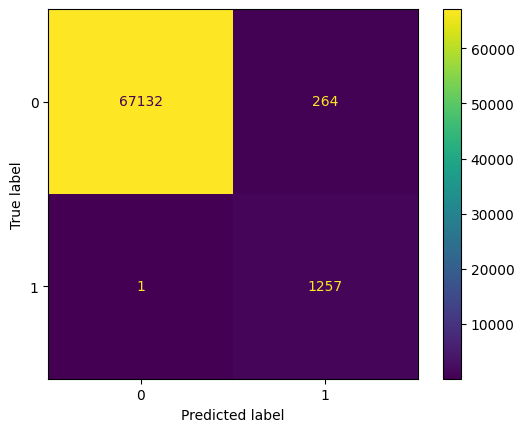

In [48]:
# Evaluate on training data
print("=== Training Data Metrics ===")
print(classification_report(y_full_train, train_preds))
ConfusionMatrixDisplay(confusion_matrix=confusion_matrix(y_full_train, train_preds)).plot()

In [49]:
# Predictions on test data
rf_preds_test = best_rf_model.predict(X_test_scaled)  # Predictions for test data
rf_probs_test = best_rf_model.predict_proba(X_test_scaled)[:, 1]  # Probabilities for test data

In [50]:
# Test predictions are saved for submission
submission = pd.DataFrame({"ID": test["ID"], "Target": rf_preds_test})
submission.to_csv("Submission.csv", index=False)
print("Submission file created: 'Submission.csv'")

Submission file created: 'Submission.csv'
